In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from helpers import *
data_folder = './DATA/'

/Users/anabelsalazardorado/opt/anaconda3/envs/ada/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/anabelsalazardorado/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anabelsalazardorado/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anabelsalazardorado/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anabelsalazardorado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package 

## Table of Contents
- [First Analysis of the character data](#section-6)
    - [A) Analysis of actors' gender and age](#subsection-6.1)
    - [B) Personas Analysis](#subsection-6.2)

# First Analysis of the character data
<a id='section-6'></a>

## A) Analysis of actors' gender and age
<a id='subsection-6.1'></a>

#### Proportion analysis
**What's the proportion of female actors in movies per year?**
We wonder if the proportion of female actors' increase over the years, which is what we would expect.

In [2]:
characters_data = pd.read_csv(data_folder+'characters_data.csv')
#adding the decade for the movies (this should be moved in the data construction)
movie_data_final = pd.read_csv(data_folder+'movie_data_final.csv')
movie_data_final['decade'] = ((movie_data_final['release_date'].astype(int))//10)*10

#doing the same for the characters
#importing the final characters dataset
final_characters = pd.read_pickle(data_folder+'final.pickle')
#adding the decade for analyses (this should also be moved in the data construction)
final_characters['decade'] = ((final_characters['release_date'].astype(int))//10)*10

/var/folders/59/tl5brg352p5flp89qk_6vy_00000gn/T/ipykernel_1489/3013405229.py:1: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  characters_data = pd.read_csv(data_folder+'characters_data.csv')


In [18]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

# interactive plot with plotly:
final_characters_grouped_by_decade = final_characters.groupby(final_characters['decade'])

# Sample data (replace this with your actual data)
decades = final_characters['decade'].unique()
proportion_female = final_characters_grouped_by_decade['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male = 1 - proportion_female

# Create a DataFrame
data = pd.DataFrame({
    'Decade': decades,
    'Male': proportion_male,
    'Female': proportion_female
})

# Create traces for male and female bars
trace_male = go.Bar(x=data['Decade'], y=data['Male'], name='Male actors', marker=dict(color='mediumturquoise'))
trace_female = go.Bar(x=data['Decade'], y=data['Female'], name='Female actors', marker=dict(color='hotpink'))

# Create layout
layout = go.Layout(
    title='Proportion of Men vs Women in Movies per Decade',
    xaxis=dict(title='Decade'),
    yaxis=dict(title='Proportion of total actors'),
    barmode='stack'
)

# Create figure
fig = go.Figure(data=[trace_female, trace_male], layout=layout)

# Show the interactive plot
fig.show()

Interestingly, the proportion of women over the decades stayed fairly constant, graphically, between 30% and 40%. This contrasts with what we expected as we would think that women representation would get better over the years. Nonetheless, it seems that the proportion of female actors has started to slowly but steadily increase since the 70s. In order to look at this increase we are going to fit a regression line starting in 1970 to model this rise. This will also allow us to estimate when, according to this trend-line, the parity will be reached.

/Users/anabelsalazardorado/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight

/Users/anabelsalazardorado/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



                            OLS Regression Results                            
Dep. Variable:             proportion   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     66.81
Date:                Fri, 15 Dec 2023   Prob (F-statistic):            0.00122
Time:                        09:04:02   Log-Likelihood:                 18.612
No. Observations:                   6   AIC:                            -33.22
Df Residuals:                       4   BIC:                            -33.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8660      0.635     -7.658      0.0

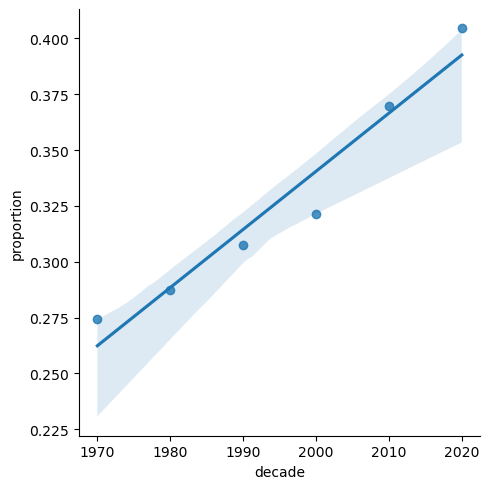

In [19]:
import statsmodels.api as sm
proportions_female_per_decade = pd.DataFrame()
proportions_female_per_decade['decade'] = proportion_female.index
proportions_female_per_decade['proportion'] = proportion_female.values

proportion_female_after1970 = proportions_female_per_decade[proportions_female_per_decade['decade']>=1970]
sns.lmplot(proportion_female_after1970, x='decade', y='proportion')

# Fit the linear model using statsmodels
X = sm.add_constant(proportion_female_after1970['decade'])
y = proportion_female_after1970['proportion']
model = sm.OLS(y, X).fit()

# Print the summary of the linear model
print(model.summary())

# Show the plot
plt.show()

We see that starting in 1970 there is a small but significant increase (p-value:0.001 and $R^2$: 0.944) per decade: per decade there is a 0.026 increase (0.0026 per year). We decided to only start this regression in 1970 as before that the proportion of women was actually decreasing (see scatter plot) before that, but we’re only interested in the upward trend we have been seeing for the past 50 years. From this it is interesting to predict, when, according to this regression 50-50 representation would occur. We know the intercept (-4.8660) and the slope (0.0026 per year). To find when the 0.5 proportion will be reached we simply need to solve the equation 0.5 = 0.0026x - 4.8660.

In [20]:
x_fifty_fifty = (0.5+4.8660)/0.0026
x_fifty_fifty

2063.846153846154

We see that fifty-fifty men and women representation should theoretically be reached in 2064. One limitation of our analysis, is that of course if we follow the trend-line there would be a point in which there would be a 100% of women representation which is not very realistic in Hollywood.

Nevertheless, this result doesn't mean that each movie has approximately 30-40% of women in their actors cast. This result might be biased by movies that have an extremely low/high proportion of women versus movies that have a balanced actors cast. To determine if that is the case, let's plot the proportion of movies per year that have 0-25% actresses, 25-50%, 50-75% or 75-100% actresses. Are female actors represented equally in every movies or is there a discrepancy between movies released in the same year?

In [21]:
# number of movies per year
number_movies_per_decade_character = final_characters_grouped_by_decade.size()

# group by decade and by movie
characters_grouped_by_decade_and_movie = final_characters.groupby(['decade', 'name'])

# Calculate the proportion of men and women per year per movie
proportion_female_per_movie = \
    characters_grouped_by_decade_and_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male_per_movie = 1 - proportion_female_per_movie

# Convert the Series to a DataFrame for easier data handling in later analysis
female_proportions = proportion_female_per_movie.reset_index()

# Rename the columns if needed
female_proportions.columns = ['decade', 'name', 'proportion_female']

In [22]:
#Lists to store in which category each movie belongs to per year
below_25_per_decade = []
quarter_50_per_decade = []
half_75_per_decade = []
above_75_per_decade = []

# Iterate through each year in the index of female_proportions
for decade, proportions in female_proportions.groupby('decade'):
    # Count movies in different categories for the current decade
    below_25 = len(proportions[proportions['proportion_female'] <= 0.25])
    quarter_50 = len(proportions[(proportions['proportion_female'] > 0.25) &
                                 (proportions['proportion_female'] <= 0.5)])
    half_75 = len(proportions[(proportions['proportion_female'] > 0.5) &
                              (proportions['proportion_female'] <= 0.75)])
    above_75 = len(proportions[proportions['proportion_female'] > 0.75])

    # Calculate proportions for each category
    total_movies = len(proportions)
    proportion_below_25 = below_25 / total_movies
    proportion_quarter_50 = quarter_50 / total_movies
    proportion_half_75 = half_75 / total_movies
    proportion_above_75 = above_75 / total_movies

    # Append proportions to respective lists
    below_25_per_decade.append(proportion_below_25)
    quarter_50_per_decade.append(proportion_quarter_50)
    half_75_per_decade.append(proportion_half_75)
    above_75_per_decade.append(proportion_above_75)

In [23]:
# Extract unique decades
unique_decades = female_proportions['decade'].unique()

# Create traces for stack plot
traces = []
categories = ['Below 25%', '25-50%', '50-75%', 'Above 75%']
data = [below_25_per_decade, quarter_50_per_decade, half_75_per_decade, above_75_per_decade]

for i, category in enumerate(categories):
    trace = go.Scatter(
        x=unique_decades,
        y=data[i],
        mode='lines',
        stackgroup='one',
        name=category
    )
    traces.append(trace)

# Create layout
layout = go.Layout(
    title='Proportion of Movies with Different Percentages of Female Actors',
    xaxis=dict(title='Decade'),
    yaxis=dict(title='Proportion of movies in a given decade'),
    legend=dict(x=1.05, y=1, traceorder='normal', orientation='v')
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

We can observe that a vast majority of movies have less than 50% of women actresses in their cast. Actually, over the years, a vast majority of movies (graphically, approximately 85%) have less than 50% female actors in their cast. Thus, even though overall the proportion of women seems to be close to 30-40% over the years, they are largely underrepresented in the vast majority of movies.
However, it might be interesting to note that from 2000 onwards there are more movies with a majority of women actors in their cast, miroring the trend of the overall increase in women's proportion in movies

#### Age analysis
**What's the age difference of female actors in movies compared to male actors over the years? Are female actors significantly younger than male actors?**

In [24]:
# drop the actors with NaN as age but also actors with negative ages (which appeared in 1910)
character_age = final_characters.dropna(subset=['actor_age']).copy()
character_age = character_age[character_age['actor_age'] >= 0] # remove actors with a negative age

In [25]:
# Group by decade and gender
characters_age_by_decade_gender = character_age.groupby(['decade', 'actor_gender'])

# Calculate average age and standard deviation of age for each gender per year
gender_age_stats_per_decade = characters_age_by_decade_gender['actor_age'].agg(['mean', 'sem'])

# Reset the index to make the grouped columns accessible for further analysis or visualization
gender_age_stats_per_decade.reset_index(inplace=True)

In [26]:
# Filter data for men and women separately for easier handling
men_data = gender_age_stats_per_decade[gender_age_stats_per_decade['actor_gender'] == 'M'].copy()
women_data = gender_age_stats_per_decade[gender_age_stats_per_decade['actor_gender'] == 'F'].copy()

# Calculate 95% confidence interval for men
men_data['lower_bound'] = men_data['mean'] - 1.96 * men_data['sem']
men_data['upper_bound'] = men_data['mean'] + 1.96 * men_data['sem']

# Calculate 95% confidence interval for women
women_data['lower_bound'] = women_data['mean'] - 1.96 * women_data['sem']
women_data['upper_bound'] = women_data['mean'] + 1.96 * women_data['sem']

In [27]:
#plot the plot with plotly to have an interactive plot
fig = go.Figure([
    go.Scatter(
        name='Men Mean Age',
        x=men_data['decade'],
        y=men_data['mean'],
        mode='lines',
        line=dict(color='mediumturquoise'),
    ),
    go.Scatter(
        name='Upper Bound',
        x = men_data['decade'],
        y = men_data['upper_bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=men_data['decade'],
        y=men_data['lower_bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(173, 216, 230, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='Women Mean Age',
        x=women_data['decade'],
        y=women_data['mean'],
        mode='lines',
        line=dict(color='hotpink'),
    ),
    go.Scatter(
        name='Upper Bound',
        x = women_data['decade'],
        y = women_data['upper_bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=women_data['decade'],
        y=women_data['lower_bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(255, 182, 193, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

# Create figure
fig.update_layout(
    yaxis_title='Age',
    xaxis_title = 'Decade',
    title='Average age of actors per decade per gender with 95% CI',
    hovermode="x",
    legend=dict(x=0, y=1, traceorder='normal', orientation='h')

)

# Show the interactive plot
fig.show()

Between decades 1910 and 2020, female actors are **significantly** younger than men at the 5% significance level. We can see that the average age of actors increase over time (both for men and women). This might be because of the long career span of actors as they usually play in several movies over the year. Thus, the actors in the 80s might be the same as the ones in the 60s, explaining why the average age of actors increases over time. In order to prove that the age difference is significantly different let's perform a 2-sided independent t-test

In [28]:
# Perform a t-test for each decade
for decade, group in character_age.groupby(['decade']):
    men = group[group['actor_gender'] == 'M']
    women = group[group['actor_gender'] == 'F']

    # Perform a t-test assuming equal variances
    t_statistic, p_value, df = sm.stats.ttest_ind(men['actor_age'], women['actor_age'])

    # Print the results
    print(f'Decade: {decade}')
    print(f'T-Statistic: {t_statistic}')
    print(f'P-Value: {p_value}')

    # Check significance level (e.g., 0.05)
    if p_value < 0.05:
        print('Statistically significant difference\n')
    else:
        print('No statistically significant difference\n')

Decade: (1910,)
T-Statistic: 23.937861450862954
P-Value: 6.689216236239643e-123
Statistically significant difference

Decade: (1920,)
T-Statistic: 25.10620178007913
P-Value: 1.1566776606663095e-133
Statistically significant difference

Decade: (1930,)
T-Statistic: 31.54907147808617
P-Value: 1.2848106654312748e-210
Statistically significant difference

Decade: (1940,)
T-Statistic: 39.800239903459946
P-Value: 0.0
Statistically significant difference

Decade: (1950,)
T-Statistic: 39.05407924583143
P-Value: 0.0
Statistically significant difference

Decade: (1960,)
T-Statistic: 31.379264192755887
P-Value: 1.2900182960965503e-206
Statistically significant difference

Decade: (1970,)
T-Statistic: 27.45803370632024
P-Value: 2.5058439602003275e-161
Statistically significant difference

Decade: (1980,)
T-Statistic: 30.066393039129252
P-Value: 2.1645515886564586e-194
Statistically significant difference

Decade: (1990,)
T-Statistic: 37.00481366332627
P-Value: 6.796412605916962e-294
Statistically 

As we can see for every decade the difference is very statistically significant, meaning we can say there is a difference between the mean age of men and women (reject the null that the mean ages are the same)

We also made an interactive plot using plotly to show the histograms of age distributions over time of men and women

In [29]:
import plotly.express as px
# Sort unique decades
decade_order = sorted(character_age['decade'].unique())

# Define a fixed y-axis range
fixed_yaxis_range = [0, 1050]

# Create the histogram using Plotly Express with a slider for decades
fig = px.histogram(
    character_age,
    x="actor_age",
    color="actor_gender",
    animation_frame="decade",
    labels={"actor_age": "Actor Age"},
    title="Age Distribution of Actors by Gender for Each Decade",
    width=1200,
    height=600,
    barmode="overlay",
    histfunc="count",
    category_orders={"decade": decade_order},
    color_discrete_map = {'M': 'mediumturquoise', 'F': 'hotpink'}
)

# Update layout for better visibility and set fixed y-axis range
fig.update_layout(
    title_x=0.5,
    title_y=0.95,
)

# Set fixed y-axis range for all subplots
for i in range(1, len(decade_order) + 1):
    fig.update_yaxes(range=fixed_yaxis_range, row=1, col=i)

# Save the plot in an HTML file and open in a new window
fig.write_html("age_distribution_plot.html", auto_open=True)

## B) Personnas Analysis
<a id='subsection-6.2'></a>

**What personas are associated with movie characters interpreted by male and female actors? Are female characters (so female actors) mostly associated with beauty, stupidity, weakness and sexualized and men mostly associated with heroism, adventure, strength...?**

In [ ]:
# For the following analysis, drop all the characters that don't have personas
characters_data_personnas_noNA = characters_data.dropna(subset=['personnas']).copy()
display(characters_data_personnas_noNA)

In [11]:
# Check values in the "actor_gender" column to make sure it is populated
characters_data_personnas_noNA.loc[characters_data_personnas_noNA.actor_gender.isna(), "actor_gender"] = "NA"
display(characters_data_personnas_noNA.groupby("actor_gender").count().actor_name)

actor_gender
F     59
M    356
Name: actor_name, dtype: int64

From this very simple line, we can already see that out of the 415 characters, only 59 are played by women, which is already a poor representation.

In [12]:
# split the dataframe in 2: one for males and one for women, which is easier for the subsequent analysis
male_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'M'].copy()
female_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'F'].copy()

In [13]:
# print the female personas with their number of occurance
unique_female_personnas_counts = female_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_female_personnas_counts = unique_female_personnas_counts.sort_values(ascending=False)
sorted_female_personnas_counts

personnas
dumb_blonde                 9
brainless_beauty            7
final_girl                  6
chanteuse                   6
prima_donna                 5
granola_person              4
broken_bird                 4
valley_girl                 3
ophelia                     3
eccentric_mentor            2
junkie_prophet              2
doormat                     1
adventurer_archaeologist    1
storyteller                 1
klutz                       1
heartbroken_badass          1
ditz                        1
classy_cat_burglar          1
bully                       1
Name: count, dtype: int64

In [14]:
# Do the same for men
unique_male_personnas_counts = male_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_male_personnas_counts = unique_male_personnas_counts.sort_values(ascending=False)
print(sorted_male_personnas_counts.head(20))

personnas
corrupt_corporate_executive    23
crazy_jealous_guy              21
psycho_for_hire                14
father_to_his_men              13
byronic_hero                   12
stoner                         11
master_swordsman                9
hitman_with_a_heart             9
arrogant_kungfu_guy             8
bounty_hunter                   8
evil_prince                     7
dirty_cop                       7
hardboiled_detective            7
tranquil_fury                   6
young_gun                       6
egomaniac_hunter                6
warrior_poet                    6
retired_outlaw                  6
slacker                         6
fastest_gun_in_the_west         6
Name: count, dtype: int64


In [15]:
# Extract the index (unique 'personas') from both DataFrames
female_personnas = sorted_female_personnas_counts.index
male_personnas = sorted_male_personnas_counts.index

# Find the intersection between the two sets of 'personas'
common_personnas = set(female_personnas) & set(male_personnas)

# Create a list of with the common personas and their count in the male and female data
common_personnas_data = [
    {
        'personna': personna,
        'female_count': sorted_female_personnas_counts.get(personna, 0),
        'male_count': sorted_male_personnas_counts.get(personna, 0),
        'normalized_ratio_F_to_M' : (sorted_female_personnas_counts.get(personna, 0)/len(female_personnas_data)) /
                                             (sorted_male_personnas_counts.get(personna, 0)/len(male_personnas_data))
    }
    for personna in common_personnas
]

# Create a DataFrame from the list of dictionaries
common_personnas_df = pd.DataFrame(common_personnas_data)
display(common_personnas_df)

,personna,female_count,male_count,normalized_ratio_F_to_M
0,eccentric_mentor,2,3,4.022599
1,doormat,1,3,2.011299
2,broken_bird,4,1,24.135593
3,brainless_beauty,7,4,10.559322
4,dumb_blonde,9,1,54.305085
5,klutz,1,1,6.033898
6,storyteller,1,3,2.011299
7,granola_person,4,4,6.033898
8,ditz,1,5,1.206780
9,adventurer_archaeologist,1,3,2.011299


This dataframe shows which personas are common for male and female as well as the count for each gender. The last column normalizes the counts of each personas for each gender and calculates how many times a given personas is more given to women than men. It is sticking how "dumb_blond" is more than 54 times more associated with women than men. Overall, terms with a bad connotation (broken_bird, dumb_blonde, brainless_beauty or bully for example) are much more associated to women than men. However, it is important to remember that the analysis is made only on 415 characters and that no statistical analysis were run on this data, which we will do in a later step of this project.

### Main Character Analysis

In [16]:
main_characters = pd.read_csv("DATA/main_characters_20_per_year")

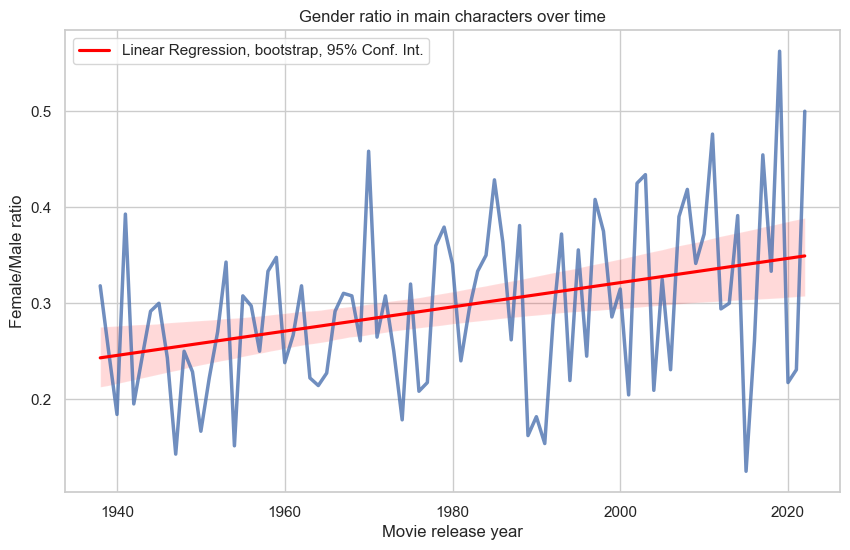

LinregressResult(slope=0.0012638536480166587, intercept=-2.2062120412998283, rvalue=0.35378552532318214, pvalue=0.0008951527878777693, stderr=0.0003667591468243959, intercept_stderr=0.7262388633716935)


In [17]:
gender_list_per_year = main_characters.groupby('release_date')['main character genders'].agg(list).reset_index()
gender_list_per_year['gender_ratio'] = \
    gender_list_per_year['main character genders'].apply(calculate_gender_ratio)
gender_list_per_year = gender_list_per_year[gender_list_per_year['gender_ratio'].notna()]
gender_list_for_plot = gender_list_per_year[20:]
plot_gender_ratio(gender_list_for_plot)

We observe an upwards trend, suggesting that female main characters have increased in popularity. This preliminary analysis is interesting, and we conclude that additional investigation into main characters is warranted.

Our method does however present limitations:
1) Most mentioned characters does not necessarily mean "main" character.
2) We do not detect characters that are not mentioned by name (e.g. "teacher", "general").
3) We miss some characters for which the name in the text is not similar enough to the official name.
4) We only observe the first 5 sentences of each summary as well as max 20 movies per year.

We aim to address these limitations for the final project milestone by reviewing our approach and by running the final pipeline on a larger dataset.